## Pokemon Legendary Predictor

### Por: @MSLacerda

## Descrição

Este é um exemplo simples de uma rede neural construída com keras(backend: Tensorflow), criaremos uma rede neural do tipo *feed-foward* supervisionada que ao final do treinamento nos fornece um modelo que é capaz de dizer, de acordo com os atritbutos, se um pokemon é lendário ou não. 

## Dependencias e Dataset

Fazemos a importação do nosso dataset e bibliotecas necessarias para a construção da rede neural.

### Camada Densa

Camada densa é basicamente uma camada densamente conectade, ou seja cada neurônio irá receber em sua entrada os dados de todos os neurônios da camada anterior.

**Cada camada processa:**
        `saida = activation(dot(input, kernel) + bias)`


In [2]:
# Usaremos um modelo do tipo sequencial de camadas
from keras.models import Sequential
from keras.utils.np_utils import to_categorical
# Callback para depurar nosso treinamento
from keras.callbacks import ModelCheckpoint
# Importamos os tipos de camadas que iremos utilizar no nossa rede neural
# Veja a explicação na notação acima
from keras.layers.core import Dense, Dropout
# Importamos Stochastic Gradient Descent para configurar a fução de otimização de nossa rede
from keras.optimizers import SGD
# Importaremos o pyplot para plotar os gráficos do histórico de treinamento
import matplotlib.pyplot as plt
# Pandas para carregar e armazenar o dataset usado par o treinamento
import pandas as pd
import numpy as np

# Data: Variável que contem o dataset original
# Importação do csv que contém os dados
data = pd.read_csv('./dataset/pokemon.csv')

Using TensorFlow backend.


## Normalizando os dados

Agora, iremos normalizar o nosso dataset para que o mesmo possa servir de entrada para a rede neural.

<ul> 
    <li> Removemos os atributos que não fornecem dados relevantes par o treinamento </li>
    <li> Removemos os atributos do tipo texto, nesse exemplo 
        simples não iremos transformar os dados em textos </li>
    <li> Criamos um dataset apenas com os valores referente ao treinamento, ou seja se é lendário
        ou não </li>
    <li> Substituímos os valores nulos por zero </li>
</ul>
    

In [3]:
X = data.drop(['abilities', 'classfication', 'type1', 'type2', 'name','percentage_male','generation', 'japanese_name', 'is_legendary', 'capture_rate'], axis=1)

normalized_Y = data[['is_legendary']]
normalized_X=(X-X.min())/(X.max()-X.min())
normalized_X = normalized_X.fillna(0)

## Dividindo os dados

Iremos dividir os dataset de treinamento e validação, em respectivamente, 75% e 25% dos dados totais. O mesmo é feito para os dados de referencia (dados de supervisão).

In [21]:
# 75% dos dados para treinamento
train_size = int(len(normalized_X) * .75)

X_train, X_test = normalized_X[0:train_size], normalized_X[train_size:len(normalized_X)]
Y_train, Y_test = normalized_Y[0:train_size], normalized_Y[train_size:len(normalized_Y)]

## Treinando o Modelo

Nossa rede é sequencial, ou seja uma rede neural *feed-foward*, as camadas são "empilhadas" e os dados seguem uma única direção.

### Input_dim: **O formato da entrada de treinamento**

A topologia de nossa rede tem esse formato:

` Camada(Entrada(16 neurônios)) ->  Camada(16 neurônios, Função de ativação="relu") -> Camada(Saída, Função de ativação="sigmoid")`

A rede tem como saída um valor entre 0 e 1, já que o o resultado pode variar apenas entre esses dois valores, é binário.

<b>É</b> ou <b>não é</b> lendário

## SGD

**SGD** é *Stochastic Gradient Descent* é a função de otimização que utilizaremos em nossa rede neural (Minimizar o *loss*), passand uma taxa de aprendizado de 0.01 (Pode experimentar aumentar a taxa e verificar o que acontece).

Veja: https://medium.com/datadriveninvestor/optimizers-for-training-neural-networks-e0196662e21e


In [121]:
input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(60, input_shape=(input_dim,), activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(60, activation="relu"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

opt = SGD(lr=0.1, momentum=0.8, nesterov=True)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
checkpoint = ModelCheckpoint('./temp_checkpoint', monitor='val_acc', verbose=0, save_best_only=False, mode='max')
history = model.fit(X_train, Y_train, epochs=10, validation_split=0.25, verbose=0, batch_size=10, callbacks=[checkpoint])
score = model.evaluate(X_test, Y_test, batch_size=10, verbose=1)

score

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_118 (Dense)            (None, 60)                1920      
_________________________________________________________________
dropout_9 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 60)                3660      
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 61        
Total params: 5,641
Trainable params: 5,641
Non-trainable params: 0
_________________________________________________________________
201/201 [==============================] - 0s 230us/step


[0.32666520829068996, 0.9651741299463149]

# Visualização dos dados de treinemanto

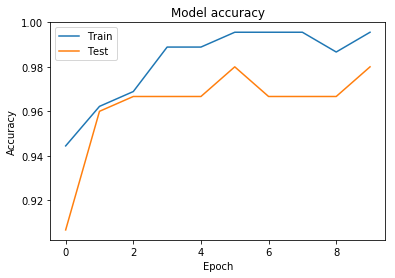

In [122]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

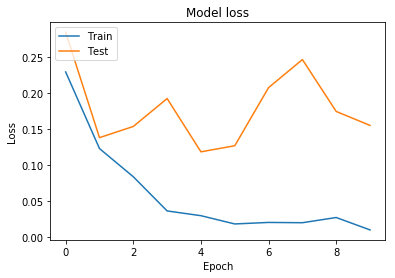

In [123]:
# Plotamos os dados resultantes do treinamento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Fazendo predições

Iremos utilizar os 25% de dados que deixamos separados para realizar os testes de predição e iremos armazenar em um dataframe personalizado os resultados.

É **Round** os resultados da predição pois a saída é baseada em uma porcentagem e queremos saber apenas se o valor é 0 ou 1.

In [124]:
# Utilizando o modelo treinando para fazer predições com os dados separados
predictions = model.predict(X_test)
# Arredondamos os valors resultados da predição
predictions_rounded = [(round(x[0]) * 100) for x in predictions]

# Pegamos os dados originais do dataset para criarmos um dataset customizado 
# com as predições
data_test = data[train_size:len(data)]

df = pd.DataFrame(columns=['name', 'is_legendary', 'prediction'])

for i in range(201):
    df = df.append({'name':data_test.iloc[i].loc['name'], 'is_legendary': ("Sim" if data_test.iloc[i].is_legendary else "Não"), 'prediction': predictions_rounded[i] }, ignore_index=True)

# Exibir o dataset
df

,name,is_legendary,prediction
0,Klinklang,Não,0.0
1,Tynamo,Não,0.0
2,Eelektrik,Não,0.0
3,Eelektross,Não,0.0
4,Elgyem,Não,0.0
5,Beheeyem,Não,0.0
6,Litwick,Não,0.0
7,Lampent,Não,0.0
8,Chandelure,Não,0.0
9,Axew,Não,0.0
